# Simple ML baseline
Implementing simple ML baseline using Neighborhood Based Collaborative Filtering approaches. The core idea it to compute a similarity score between playlists and use the songs in these similar playlists for prediction. 

Note that this algorithm is presented in Ch2 of Reccomender Systems by Aggarwal in the context of ratings prediction. Note that the playlist
prediction problem is different since we have only implicit information about the prefferences of each playlist through the inclusion of each
song on the playlist, but we have no negative ratings of songs. As a result, the method implemented below is altered to apply to our setting

Just as in the baselines, I am only working with 10% of the dataset

- Load in training data and create pid -> set{track_ids} 
- load in validation data
- for each playlist in validation dataset
    - place all seen songs (X) in a set and compute a similarity score between X and all other training playlists
    - for the top k most similar playlists to X, sort these neighboring songs by frequency.
    - predict the most frequent songs from the neighborhood that are not already in X



Q: What if there are no playlists in the neighborhood?

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
from collections import defaultdict
from util import parse_playlist_dataset
from util import R_precision
from util import create_validation_data
from util import plot_percentage_distribution, plot_clicks_needed_distribution

In [2]:
# subsets of dataset we are using
VAL_START = 0
VAL_END = 10
TRAIN_START = 10
TRAIN_END = 50

In [3]:
def construct_id_to_songname(lower_bound, upper_bound):
    # lookup from track_id to name for all songs
    _, df_tracks_train_all,_ = parse_playlist_dataset(start_range=lower_bound, end_range=upper_bound)
    uri_to_songname = defaultdict(int)
    for uri, name in zip(df_tracks_train_all["track_uri"], df_tracks_train_all["track_name"]):
        uri_to_songname[uri] = name
    print(f"total number of unique songs in the dataset: {len(uri_to_songname)}")
    return uri_to_songname
uri_to_songname = construct_id_to_songname(VAL_START, TRAIN_END)

Number of files being extracted: 50
['spotify_train_set/data/mpd.slice.0-999.json', 'spotify_train_set/data/mpd.slice.1000-1999.json', 'spotify_train_set/data/mpd.slice.10000-10999.json', 'spotify_train_set/data/mpd.slice.100000-100999.json', 'spotify_train_set/data/mpd.slice.101000-101999.json', 'spotify_train_set/data/mpd.slice.102000-102999.json', 'spotify_train_set/data/mpd.slice.103000-103999.json', 'spotify_train_set/data/mpd.slice.104000-104999.json', 'spotify_train_set/data/mpd.slice.105000-105999.json', 'spotify_train_set/data/mpd.slice.106000-106999.json', 'spotify_train_set/data/mpd.slice.107000-107999.json', 'spotify_train_set/data/mpd.slice.108000-108999.json', 'spotify_train_set/data/mpd.slice.109000-109999.json', 'spotify_train_set/data/mpd.slice.11000-11999.json', 'spotify_train_set/data/mpd.slice.110000-110999.json', 'spotify_train_set/data/mpd.slice.111000-111999.json', 'spotify_train_set/data/mpd.slice.112000-112999.json', 'spotify_train_set/data/mpd.slice.113000-113

In [4]:
# construct {pid -> set(track_uri)} for training data
df_playlist_song_train, _, _ = parse_playlist_dataset(start_range=TRAIN_START, end_range=TRAIN_END)
neighbor_candidates = defaultdict(set)

for _, row in df_playlist_song_train.iterrows():
    neighbor_candidates[row["pid"]].add(row["track_uri"])
assert(len(neighbor_candidates.keys()) == 40*1000)

Number of files being extracted: 40
['spotify_train_set/data/mpd.slice.107000-107999.json', 'spotify_train_set/data/mpd.slice.108000-108999.json', 'spotify_train_set/data/mpd.slice.109000-109999.json', 'spotify_train_set/data/mpd.slice.11000-11999.json', 'spotify_train_set/data/mpd.slice.110000-110999.json', 'spotify_train_set/data/mpd.slice.111000-111999.json', 'spotify_train_set/data/mpd.slice.112000-112999.json', 'spotify_train_set/data/mpd.slice.113000-113999.json', 'spotify_train_set/data/mpd.slice.114000-114999.json', 'spotify_train_set/data/mpd.slice.115000-115999.json', 'spotify_train_set/data/mpd.slice.116000-116999.json', 'spotify_train_set/data/mpd.slice.117000-117999.json', 'spotify_train_set/data/mpd.slice.118000-118999.json', 'spotify_train_set/data/mpd.slice.119000-119999.json', 'spotify_train_set/data/mpd.slice.12000-12999.json', 'spotify_train_set/data/mpd.slice.120000-120999.json', 'spotify_train_set/data/mpd.slice.121000-121999.json', 'spotify_train_set/data/mpd.slic

In [5]:
# generate validation dataset for first 5 playlists
playlist_to_track_val = create_validation_data(start_range=VAL_START, end_range=VAL_END)

Number of files being extracted: 10
['spotify_train_set/data/mpd.slice.0-999.json', 'spotify_train_set/data/mpd.slice.1000-1999.json', 'spotify_train_set/data/mpd.slice.10000-10999.json', 'spotify_train_set/data/mpd.slice.100000-100999.json', 'spotify_train_set/data/mpd.slice.101000-101999.json', 'spotify_train_set/data/mpd.slice.102000-102999.json', 'spotify_train_set/data/mpd.slice.103000-103999.json', 'spotify_train_set/data/mpd.slice.104000-104999.json', 'spotify_train_set/data/mpd.slice.105000-105999.json', 'spotify_train_set/data/mpd.slice.106000-106999.json']


In [6]:
'''
return k most similar songs based on a neighborhood of other playlists
'''
def playlist_similarity(query: set[str], neighbors: dict[int, set[str]], k: int):
    # compute similarity for each of the neighbors

    sim = {pid:len(neighbors[pid].intersection(query))/(len(neighbors[pid])) for pid in neighbors.keys()}
    top_k = sorted(sim.keys(), key=lambda x: sim[x], reverse=True) # pids with more in common with query playlist

    # generate k playlists and compute frequency of playlists in this neighborhood 
    song_freq_in_neighborhood = defaultdict(int)
    neighborhood_size = 0
    for neighbor_id in top_k:
        neighborhood_size += 1
        for song in neighbors[neighbor_id]:
            if song in query: continue
            song_freq_in_neighborhood[song] += 1
        if(len(song_freq_in_neighborhood) >= 500): break # max number of clicks is 50
    candidate_preds = sorted(song_freq_in_neighborhood.keys(), key=lambda x: song_freq_in_neighborhood[x], reverse=True)

    return candidate_preds, neighborhood_size, sim


r_prec 0.0 

Songs we saw in the playlist: ['Eye of the Tiger', 'Libera Me From Hell (Tengen Toppa Gurren Lagann)', 'Pokémon Theme', 'Concerning Hobbits (The Lord of the Rings)', 'The Blood of Cuchulainn (The Boondock Saints)', "He's a Pirate (Pirates of the Caribbean)", "Very Bloody Tears (Castlevania II: Simon's Quest)", 'U.N. Owen Was Her? (Remix)', 'I am the Doctor in Utah', 'The Room Where It Happens', 'Right Hand Man', 'Alexander Hamilton', 'My Shot', 'Stairway To Heaven', 'Shine', 'Ghost Love Score', 'Crazy', 'Sympathy For The Devil', 'Gimme Shelter']
Songs we predicted: ['Aaron Burr, Sir', 'Burn', 'Cabinet Battle #1', 'Guns and Ships', 'History Has Its Eyes On You', "It's Quiet Uptown", 'Meet Me Inside', 'Non-Stop', 'Start Me Up - Remastered', 'Stay Alive', 'Take A Break', 'That Would Be Enough', 'The Reynolds Pamphlet', 'Wait For It', 'Washington On Your Side', 'We Know', 'What Comes Next?', "What'd I Miss", 'Yorktown (The World Turned Upside Down)', 'Your Obedient Servant']
G

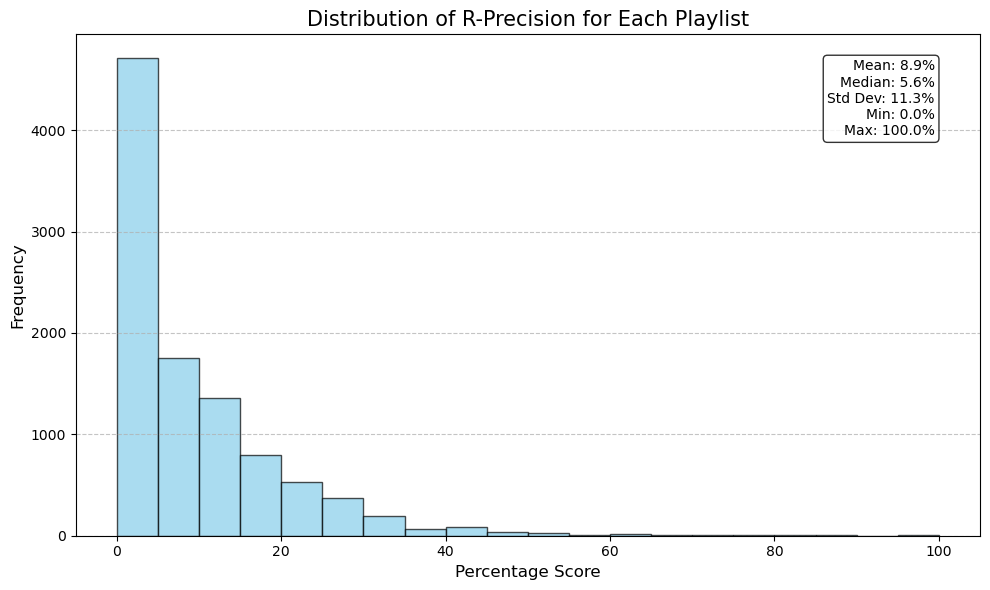

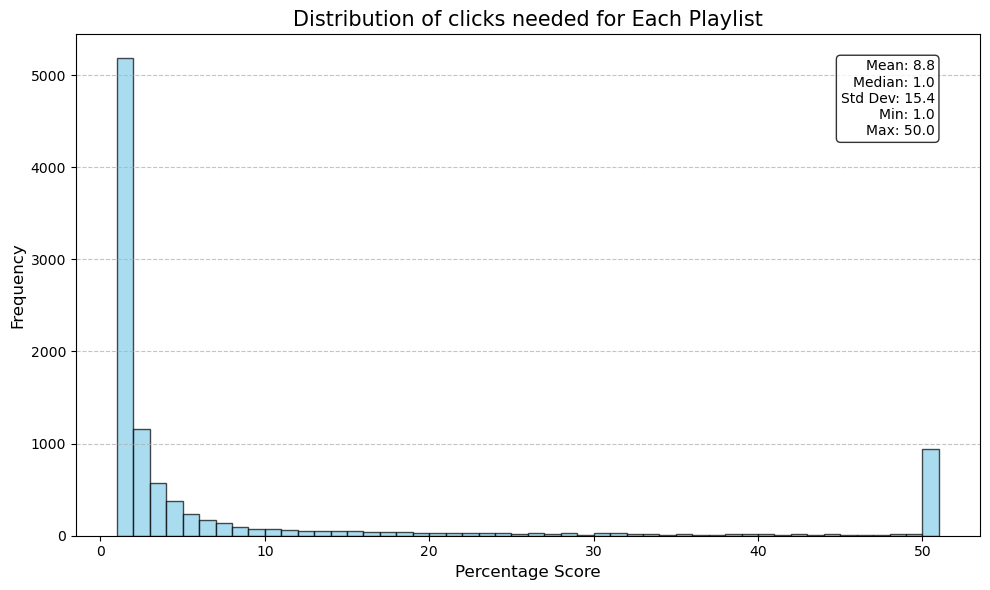

Total Percentage of correctly predicted songs across all playlists: 10.192887641455913


In [14]:
# nearest neighbor calculation
r_precs = []
num_clicks_list = []
total_matches = 0
total_heldouts = 0

worst_example = False
best_example = False

# loop over validation set and compute metrics of interest for naive models
for pid in playlist_to_track_val.keys():
    seen_songs = playlist_to_track_val[pid]['seen']
    heldout_songs = set(playlist_to_track_val[pid]['heldout']) # sometimes there are dups and I dont know why?
    preds = set()
    total_heldouts += len(heldout_songs)

    # compute similarity between this set of songs and all the pre-computed neighbors
    candidate_preds, neighborhood_size, pid_to_sim_score = playlist_similarity(seen_songs, neighbor_candidates, len(heldout_songs))

    # generate predictions from most frequent songs in neighborhood on already in the playlist
    for candidate in candidate_preds:
        if candidate in seen_songs: continue
        preds.add(candidate)
        if len(preds) == len(heldout_songs): break
    
    # compute num_clicks needed 
    num_clicks = 0
    song_idx = 0
    found_good_song = False
    while num_clicks < 50:
        num_clicks += 1
        i = 0
        while(i < 10):
            candidate = candidate_preds[song_idx]
            song_idx += 1
            if candidate in seen_songs: continue
            i += 1
            if candidate in heldout_songs: 
                found_good_song = True
                break
        if found_good_song: break   
    num_clicks_list.append(num_clicks)

    # compute Precision from these predictions
    r_prec, num_matches = R_precision(preds, heldout_songs)
    r_precs.append(r_prec)
    total_matches += num_matches
    if(r_prec == 0 and not worst_example):
        worst_example = True
        print(f"r_prec {r_prec} \n")
        print(f"Songs we saw in the playlist: {list(map(lambda x: uri_to_songname[x], seen_songs))}")
        print(f"Songs we predicted: {sorted(list(map(lambda x: uri_to_songname[x], preds)))}")
        print(f"Ground truth songs{sorted(list(map(lambda x: uri_to_songname[x], heldout_songs)))}")
        print(f"Number of neighbors we considered: {neighborhood_size}")
        print(f"Sim Score of 20 nearest neighbors: {list(sorted(pid_to_sim_score.values(), reverse=True)[:20])}")
        print("\n")
    if(r_prec == 1 and not best_example): # print out the best playlist we predicted
        best_example = True
        print(f"r_prec {r_prec} \n")
        print(f"Songs we saw in the playlist: {list(map(lambda x: uri_to_songname[x], seen_songs))}")
        print(f"Ground truth songs{sorted(list(map(lambda x: uri_to_songname[x], heldout_songs)))}")
        print(f"Number of neighbors we considered: {neighborhood_size}")
        print(f"Sim Score of 20 nearest neighbors: {list(sorted(pid_to_sim_score.values(), reverse=True)[:20])}")
        print("\n")
    
scores_np = np.array(r_precs) * 100
plot_percentage_distribution(scores_np)
plot_clicks_needed_distribution(num_clicks_list)
print(f"Total Percentage of correctly predicted songs across all playlists: {100 * total_matches/total_heldouts}")